In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
import torch
from tqdm.auto import tqdm
import re

# NLTK for stemming and lemmatization
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

# Suppressing warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Loading data
train_df = pd.read_csv('/kaggle/input/sentiment/movie_reviews/movie_reviews.csv')
test_df = pd.read_csv('/kaggle/input/sentiment/test_data.csv')

# Display first 5 examples
print("📊 Examples from train_df:")
print(train_df[['text', 'label']].head(5).to_string(index=False))
print("-" * 50)

📊 Примеры данных из train_df:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [3]:
# Text cleaning and normalization function
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<br\s*/?>', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    
    # Tokenization
    tokens = text.split()
    
    # Stemming and lemmatization
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(stemmer.stem(word)) for word in tokens]
    
    return ' '.join(tokens)

# Apply to train and test
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

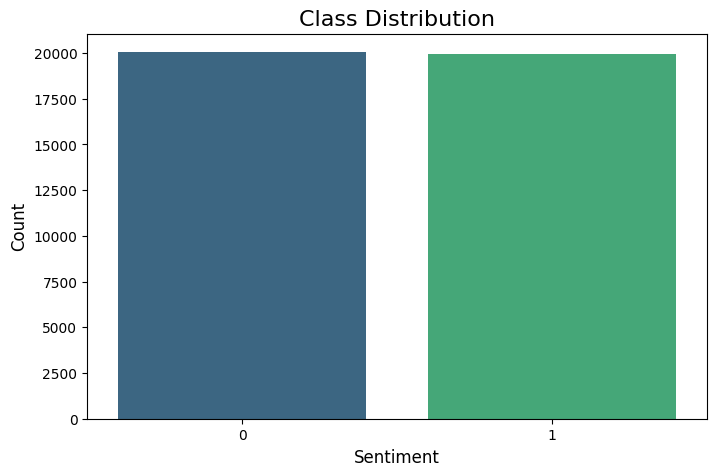

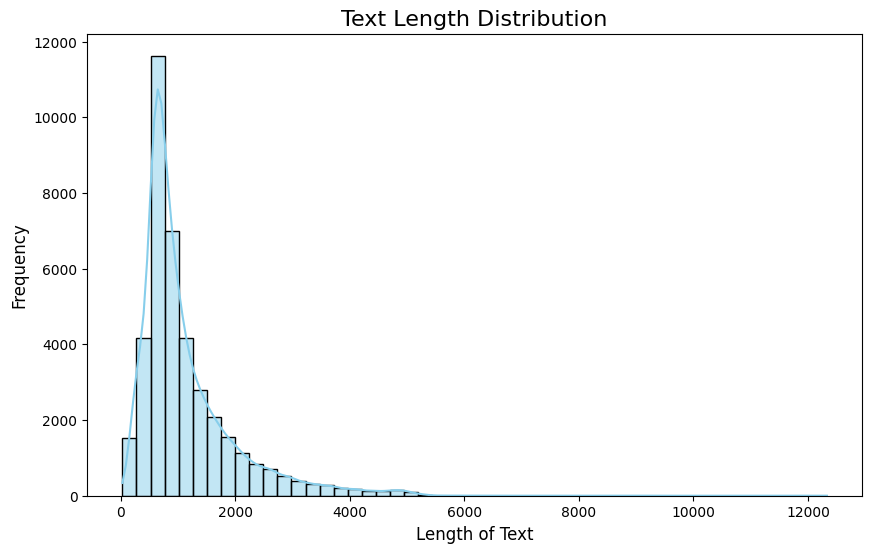

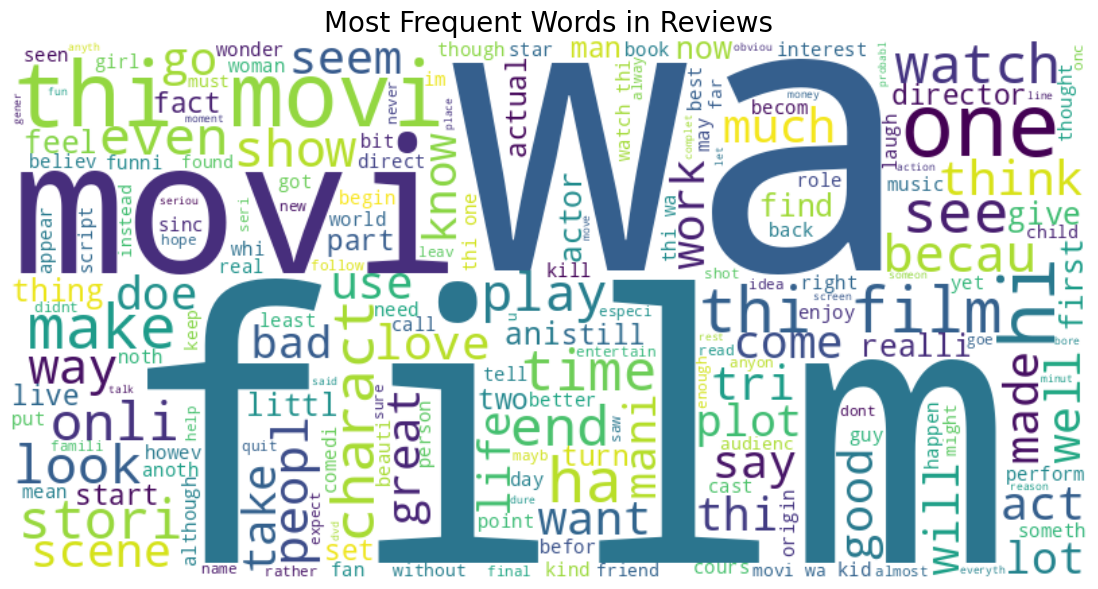

In [4]:
# --- Class Distribution ---
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=train_df, palette="viridis")
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.savefig('class_distribution.png')
plt.show()

# --- Text Length ---
train_df['text_length'] = train_df['cleaned_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=50, color='skyblue', kde=True)
plt.title('Text Length Distribution', fontsize=16)
plt.xlabel('Length of Text', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('text_length_distribution.png')
plt.show()

# --- Frequent Words: Word Cloud ---
def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='viridis').generate(text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.savefig(f'{title}.png')
    plt.show()

all_text = ' '.join(train_df['cleaned_text'])
plot_word_cloud(all_text, 'Most Frequent Words in Reviews')

In [5]:
# Model setup
MODEL_NAME = "dfurman/deberta-v3-base-imdb"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Dataset class
class ReviewDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        output = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

        if self.labels is not None:
            output['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return output

# Data splitting
X_train, X_val, y_train, y_val = train_test_split(
    train_df['cleaned_text'], train_df['label'],
    test_size=0.1, stratify=train_df['label'], random_state=42
)

# DataLoader
BATCH_SIZE = 16
MAX_LEN = 256

train_dataset = ReviewDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
val_dataset = ReviewDataset(X_val.tolist(), y_val.tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

2025-05-27 17:49:57.373247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748368197.559211      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748368197.609144      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

In [6]:
import os

# Folder to save the model
MODEL_SAVE_PATH = 'best_model.pt'

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Accuracy function
def calculate_accuracy(preds, targets):
    return (torch.argmax(preds, dim=1) == targets).float().mean().item()

# Initialize best accuracy
best_val_acc = 0.0

# Training
NUM_EPOCHS = 4

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    train_acc = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)

    for batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        preds = outputs.logits
        train_acc += calculate_accuracy(preds, labels)

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    # Validation
    model.eval()
    val_acc = 0
    val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]  ", leave=False)

    with torch.no_grad():
        for batch in val_progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits
            val_acc += calculate_accuracy(preds, labels)

    avg_val_acc = val_acc / len(val_loader)

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_acc:.4f} | Val Accuracy: {avg_val_acc:.4f}")
    print("-" * 50)

    # Save model if validation accuracy improved
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"New best model saved with Val Accuracy: {best_val_acc:.4f}")

# Load best model before prediction
print("Loading best model for prediction...")
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model = model.to(device)
model.eval()


Epoch 1/4 [Train]:   0%|          | 0/2250 [00:00<?, ?it/s]

Epoch 1/4 [Val]  :   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 1/4
Train Loss: 0.1890 | Train Accuracy: 0.9273 | Val Accuracy: 0.9405
--------------------------------------------------
New best model saved with Val Accuracy: 0.9405


Epoch 2/4 [Train]:   0%|          | 0/2250 [00:00<?, ?it/s]

Epoch 2/4 [Val]  :   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 2/4
Train Loss: 0.1229 | Train Accuracy: 0.9557 | Val Accuracy: 0.9405
--------------------------------------------------


Epoch 3/4 [Train]:   0%|          | 0/2250 [00:00<?, ?it/s]

Epoch 3/4 [Val]  :   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 3/4
Train Loss: 0.0790 | Train Accuracy: 0.9742 | Val Accuracy: 0.9430
--------------------------------------------------
New best model saved with Val Accuracy: 0.9430


Epoch 4/4 [Train]:   0%|          | 0/2250 [00:00<?, ?it/s]

Epoch 4/4 [Val]  :   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 4/4
Train Loss: 0.0559 | Train Accuracy: 0.9821 | Val Accuracy: 0.9387
--------------------------------------------------
Loading best model for prediction...


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [7]:
# Prediction
test_dataset = ReviewDataset(test_df['cleaned_text'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

predictions = []
progress_bar_test = tqdm(test_loader, desc="Predicting Test Data")

with torch.no_grad():
    for batch in progress_bar_test:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        predictions.extend(preds)

# Save submission
submission = pd.DataFrame({
    'Id': test_df['Id'].astype(int),
    'Category': predictions
})
submission.to_csv('submission.csv', index=False)

print("Submission file created!")

Predicting Test Data:   0%|          | 0/625 [00:00<?, ?it/s]

Submission file created!
